## Illustrate how to tranform data matrix into pictures

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [4]:
import os
filepath = 'Documents/GaTech/Sem 2/ISyE 6740 - CDA/Project/archive'
os.chdir(os.path.expanduser('~/'))
os.chdir(filepath)
os.getcwd()

'/Users/sanchitdighe/Documents/GaTech/Sem 2/ISyE 6740 - CDA/Project/archive'

In [7]:
#os.listdir('Happy')

### Read Images from File

In [10]:
#X_data = {'Happy':[], 'Fear':[], 'Neutral':[], 'Angry':[], 'Disgust':[]}
X_data = []
y = []
for files in os.listdir():
    if not files.startswith('.'):
        print(files)
        #print(os.listdir(files))
        for image in os.listdir(files):
            path = f"{files}/{image}"
            data = cv2.imread(path) # Reads image in BGR format
            data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY) # Convert to Grayscale
            X_data.append (data)
        for j in range(len(os.listdir(files))):
            y.append(files)

        


Happy
Fear
Neutral
Angry
Disgust


In [11]:
X_data = np.asarray(X_data).astype('float32')

In [12]:
X_data.shape
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

X_data = X_data/255
X_data[:,:,1]

array([[0.2       , 0.18431373, 0.21568628, ..., 0.2509804 , 0.27058825,
        0.28627452],
       [0.29411766, 0.30980393, 0.23529412, ..., 0.84313726, 0.8156863 ,
        0.78431374],
       [0.8509804 , 0.9254902 , 0.9372549 , ..., 0.8235294 , 0.8156863 ,
        0.79607844],
       ...,
       [0.24705882, 0.25882354, 0.27450982, ..., 0.21568628, 0.23921569,
        0.22745098],
       [0.75686276, 0.78039217, 0.6901961 , ..., 0.25490198, 0.24313726,
        0.23921569],
       [0.75686276, 0.78039217, 0.6901961 , ..., 0.25490198, 0.24313726,
        0.23921569]], dtype=float32)

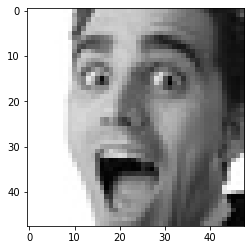

(48, 48)

In [13]:
path = "Happy/Training_77412.jpg"
data = cv2.imread(path)
data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
plt.imshow(data, cmap='Greys_r')
plt.show()
data.shape

### Split Data into Train and Test

In [14]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.25, random_state = 42)




#### Convert Y labels to Numpy Arrays

In [15]:
Y_train = np.asarray(y_train)
Y_test = np.asarray(y_test)

## Decompose Training Images using CP and Tucker Decomposition

#### Import Tensorly Library

In [16]:
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from tensorly.tenalg import mode_dot

#### Decompose Training Set with CP & Tucker

In [12]:
X_train_cp = np.empty(shape=(48,48, len(X_train)),dtype='float32') #CP
rank_cp = 5

rank_tuck = [5,5]
X_train_tuck = np.empty(shape=(rank_tuck[0], rank_tuck[1], len(X_train)), dtype='float32') #Tucker

for i in range(len(X_train)): # i iterates through all images
    # Specify the tensor
    X = tl.tensor(X_train[i].astype(float))
    
    # Perform CP decompositon using TensorLy
    factors_tl = parafac(X, rank=rank_cp)
    a, b = factors_tl
    b1 = []
    b2 = []
    for j in range(rank_cp): # j iterates through all ranks
        b1 = b[0][:,j].reshape(-1,1).astype(np.float32)
        b2 = b[1][:,j].reshape(-1,1).astype(np.float32)
        X_train_cp[:,:,i] = X_train_cp[:,:,i] + np.tensordot(b1, b2.T, axes=1)
    
    # Perform Tucker Decomposition using TensorLy
    X_train_tuck[:,:,i], factors = tucker(X, rank=rank_tuck)

#### Decompose Testing Set with CP
* For Tucker, we'll use the Tucker factorizing matrices computed above from training set to compute the core test matrix

In [13]:
X_test_cp = np.empty(shape=(48,48, len(X_test)),dtype='float32') #CP

#core_test = np.empty(shape=(rank_tuck[0], rank_tuck[1], len(X_test)), dtype='float32') #Tucker

for i in range(len(X_test)): # i iterates through all images
    # Specify the tensor and the rank
    X, rank = tl.tensor(X_test[i].astype(float)), 5
    
    # Perform CP decompositon using TensorLy
    factors_tl = parafac(X, rank=rank_cp) 
    a, b = factors_tl
    b1 = []
    b2 = []
    for j in range(rank_cp): # j iterates through all ranks
        b1 = b[0][:,j].reshape(-1,1).astype(np.float32)
        b2 = b[1][:,j].reshape(-1,1).astype(np.float32)
        X_test_cp[:,:,i] = X_test_cp[:,:,i] + np.tensordot(b1, b2.T, axes=1)
    
    # Perform Tucker Decomposition using TensorLy
    #rank_tuck = [5,5]
    #core_test[:,:,i], factors = tucker(X, rank=rank_tuck)

* Flatten train and test inputs of CP Decomposed Images for Classifier

In [14]:
X_train_cp = X_train_cp.reshape(X_train_cp.shape[2],-1)
X_test_cp = X_test_cp.reshape(X_test_cp.shape[2],-1)

* Compute Test Inputs for Tucker Decomposed Images using Tensor-Matrix Multiplication

In [15]:
factors_tuck = np.asarray(factors)
#X_test_tuck = np.zeros((len(X_test),5,5))
X_test_tuck =[]
for i in range(len(X_test)):
    X = tl.tensor(X_test[i].astype(float))
    c1 = mode_dot(X, factors_tuck[0],0, transpose=True)
    
    X_test_tuck.append(mode_dot(c1, factors_tuck[1],1, transpose=True))



* Flatten train and test inputs of Tucker Decomposed Images for Classifier

In [16]:
X_train_tuck = X_train_tuck.reshape(X_train_tuck.shape[2],-1)
X_test_tuck = np.asarray(X_test_tuck)
X_test_tuck = X_test_tuck.reshape(X_test_tuck.shape[0],-1)

In [17]:
#plt.imshow(X_train[1], cmap='Greys_r')

### Fit RandomForest Classifier on CP Decomposed Images

In [37]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf_cp = RandomForestClassifier(n_estimators = 500, random_state = 42, max_depth=6)
# Train the model on training data
rf_cp.fit(X_train_cp, Y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [38]:
rf_cp.predict(X_test_cp)

array([3, 3, 3, ..., 3, 3, 3])

In [39]:
np.sum(rf_cp.predict(X_test_cp)==Y_test)/len(Y_test)

0.4069684759421664

### Fit RandomForest Classifier on Tucker Decomposed Images

In [40]:
## Random Forest using Tucker Decomposition

# Instantiate model with 100 decision trees
rf_tuck = RandomForestClassifier(n_estimators = 500, random_state = 42, max_depth=6)
# Train the model on training data
rf_tuck.fit(X_train_tuck, Y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [41]:
rf_tuck.predict(X_test_tuck)

array([3, 3, 3, ..., 3, 3, 3])

In [42]:
np.sum(rf_tuck.predict(X_test_tuck)==Y_test)/len(Y_test)

0.40388717705617444

In [43]:
X_test.shape

(4219, 2304)

### Fit RandomForest Classifier on Non-Decomposed Images

In [17]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [45]:
## Random Forest using Tucker Decomposition

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42, max_depth=6)
# Train the model on training data
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [46]:
rf.predict(X_test)

array([3, 3, 4, ..., 1, 3, 3])

In [47]:
np.sum(rf.predict(X_test)==Y_test)/len(Y_test)

0.5479971557241052

### Fit Multi-Layer Perceptron Model

In [19]:
from sklearn.neural_network import MLPClassifier
#import pickle5 as pickle

nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 5, 5), random_state=42)

nn.fit(X_train, Y_train)

#with open('nnmodel.pkl','wb') as f:
#    pickle.dump(nn,f)

print('Training accuracy: ', nn.score(X_train, Y_train))
print('Testing accuracy: ', nn.score(X_test, Y_test))


Training accuracy:  0.5092834004898475
Testing accuracy:  0.46622422374970374


/Users/sanchitdighe/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
df['emotion'].mask(df['emotion'] == 0, 'Anger', inplace=True)
df['emotion'].mask(df['emotion'] == 1, 'Disgust', inplace=True)
df['emotion'].mask(df['emotion'] == 2, 'Fear', inplace=True)
df['emotion'].mask(df['emotion'] == 3, 'Happy', inplace=True)
df['emotion'].mask(df['emotion'] == 4, 'Sad', inplace=True)
df['emotion'].mask(df['emotion'] == 5, 'Surprise', inplace=True)
df['emotion'].mask(df['emotion'] == 6, 'Neutral', inplace=True)

In [ ]:
df

In [ ]:
for i in range(5):
    r = np.random.randint((1), 24000, 1)[0]
    plt.figure()
    img = df.iloc[r]['pixels'].split()
    img = [int(i) for i in img]
    img = np.array(img)
    img = img.reshape(48,48)
    plt.imshow(img, cmap='gray')
    plt.xlabel(df.iloc[r]['emotion'])